# Face Recognation 
Project based on: [Build a Deep Facial Recognition App](https://www.youtube.com/watch?v=bK_k7eebGgc&list=PLgNJO2hghbmhHuhURAGbe6KWpiYZt0AMH)

# 1. Set up and get data

# 1.1 Install dependencies

!pip install tensorflow

In [24]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

## 1.2 Collect images using openCV

In [3]:
import os
import time
import uuid # for unique id
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import albumentations as alb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

2024-05-10 15:54:30.162478: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
IMAGES_PATH = os.path.join('data', 'images')
NUM_IMAGES_TO_COLLECT = 20

In [56]:
# Conection to video camera and get images
cap = cv2.VideoCapture(0) # if you are on winodws try 1 instead of 0
for imgnum in range(NUM_IMAGES_TO_COLLECT):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'): # turn off the camera
        break
cap.release()
cv2.destroyAllWindows()

## 1.3 Annotate images with labelMe

In [57]:
#/Users/asialalala/.local/pipx/venvs/labelme/bin/labelme
!labelme

/bin/bash: labelme: command not found


# 2. Review Dataset and Build Image Loading Function

## 2.1 Import packages

## 2.2 Limit GPU Memory Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# WARNING!!!! It should be trye, but it is false

In [6]:
# check if tensorflow is available
tf.config.list_physical_devices('GPU')
#tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [7]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

In [8]:
# variable 'images' contains path to images files
images.as_numpy_iterator().next()

b'data/images/bb619074-0ed4-11ef-beac-64d2c4ecd148.jpg'

In [9]:
# read images and load them as jpeg to img
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [10]:
images = images.map(load_image)

In [11]:
images.as_numpy_iterator().next()

array([[[117, 120, 113],
        [142, 145, 138],
        [116, 119, 112],
        ...,
        [ 81,  80,  85],
        [ 85,  85,  87],
        [ 89,  89,  91]],

       [[140, 143, 136],
        [141, 144, 137],
        [119, 122, 115],
        ...,
        [ 74,  73,  78],
        [ 82,  82,  84],
        [ 87,  87,  89]],

       [[101, 106, 100],
        [107, 112, 106],
        [122, 124, 119],
        ...,
        [ 67,  65,  70],
        [ 73,  71,  74],
        [ 84,  82,  85]],

       ...,

       [[128, 135, 143],
        [126, 133, 141],
        [128, 132, 141],
        ...,
        [ 94,  93,  99],
        [ 94,  93,  99],
        [ 87,  86,  92]],

       [[137, 142, 148],
        [127, 132, 138],
        [122, 125, 132],
        ...,
        [100, 101, 106],
        [ 91,  90,  95],
        [ 88,  87,  92]],

       [[128, 133, 139],
        [127, 132, 138],
        [124, 127, 134],
        ...,
        [112, 113, 118],
        [ 90,  89,  94],
        [ 85,  84,  89]]

## 2.4 View Raw Images with Matplotlib

In [12]:
image_genarator = images.batch(4).as_numpy_iterator()

In [13]:
plot_images = image_genarator.next() #geting new batch of data, can be ran multiple time

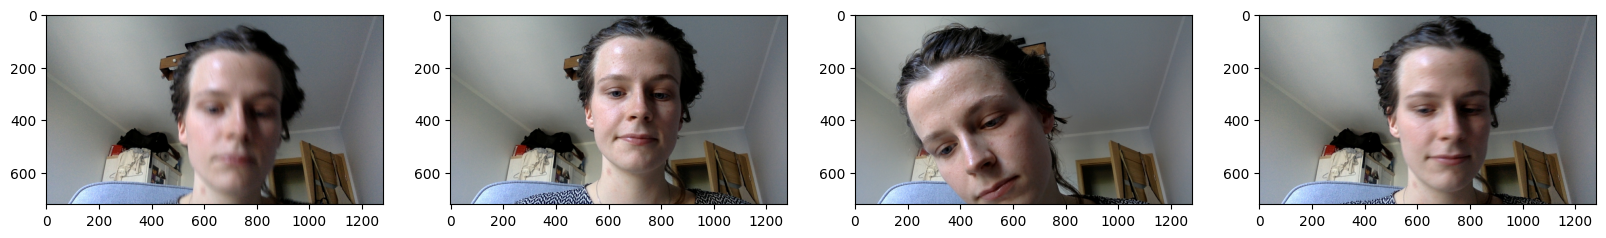

In [14]:
#show 4 images, if you want another butch just ran cell below and then this one
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()                      

# 3. Partition Unaugmented Data

## 3.1 Manually Split Sata into Train Test and Val

In [15]:
#if we add new data we need to also divide it and add to folders

In [16]:
176*0.7 #123 to train

123.19999999999999

In [17]:
176*.15 # 26 and 27 to test and val

26.4

## 3.2 Move the Matching Labels

In [18]:
#moving matching labels to the photos in new folders
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath) 
#i'm not sure if it do it for all files but it did for some

# 4. Apply Image Augmentation on Images and Labels using Albumentations

## 4.1 Setup Albumentations Transform Pipline

In [19]:
#adjust photos and normalization (bbox)
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))


## 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [20]:
img = cv2.imread(os.path.join('data','train','images','547b89de-07fc-11ef-b710-64d2c4ecd148.jpg')) #if dosen't return error -> works

In [21]:
with open(os.path.join('data','train','labels','547b89de-07fc-11ef-b710-64d2c4ecd148.json'), 'r') as f:
    label = json.load(f)

In [22]:
#label #to check if it works, also can check type or use label['shapes'] or label['shapes'][0]['points'] for coordinate

## 4.3 Extract Cooridnates and Rescale to Match Image Resolution

In [23]:
coords = [0,0,0,0]
coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]

In [24]:
coords #vector with coordinates

[327.1212121212122, 53.939393939393966, 727.1212121212122, 561.5151515151515]

In [25]:
#this adjust to picture width and height and works better
img_width = img.shape[1] #x
img_height = img.shape[0] #y
coords = list(np.divide(coords, [img_width, img_height, img_width, img_height]))

In [26]:
coords

[0.255563446969697, 0.07491582491582495, 0.568063446969697, 0.7798821548821548]

## 4.4 Apply Augmentation and View Results

In [27]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face']) 

In [28]:
augmented['bboxes']

[(0.0, 0.0, 0.8580471380471383, 0.6767003367003367)]

In [29]:
len(augmented['bboxes'])

1

In [30]:
type(augmented['image'])

numpy.ndarray

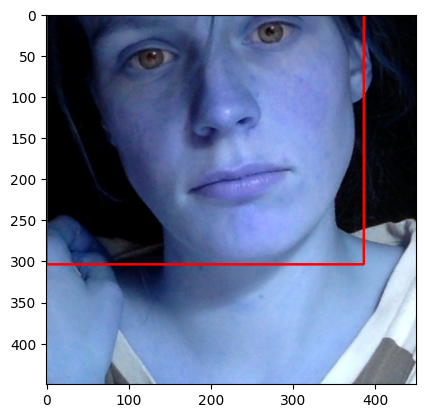

In [31]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0),2)

plt.imshow(augmented['image']) #can be blue its still correct

# 5. Bulid and Run Augmentation Pipeline

## 5.1 Run Augmentation Pipeline

In [68]:
for folder in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', folder, 'images')):
        img = cv2.imread(os.path.join('data', folder, 'images', image))

        coords = [0, 0, 0.00001, 0.00001]
        filename = image.split('.')[0] + '.json'
        label_path = os.path.join('data', folder, 'labels', filename)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            img_width = img.shape[1] # x
            img_height = img.shape[0] # y
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [img_width, img_height, img_width, img_height]))

        try:
            for x in range(60):  #create 60 new images for every image in Database
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                
                new_image_name = f'{image.split(".")[0]}_{x}.jpg'  
                cv2.imwrite(os.path.join('aug_data', folder, 'images', new_image_name), augmented['image'])

                annotation = {}
                annotation['image'] = image  

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bboxes'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bboxes'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bboxes'] = [0, 0, 0, 0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', folder, 'labels', f'{image.split(".")[0]}_{x}.json'), 'w') as f: 
                    json.dump(annotation, f)
        except Exception as e:
            print(e)
                        

image must be numpy array type
image must be numpy array type


## 5.2 Load Augmented Images to Tensorflow Dataset

In [32]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/225) #scaling and resize towork better at network while teaching

In [33]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/225)

In [34]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/225)

# 6. Prepare Labels

## 6.1 Build Label Loading Function

In [35]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']],label['bboxes']

## 6.2 Load Labels to Tensorflow Dataset

In [36]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [37]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [38]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# 7. Combine Label and Image Samples

## 7.1 Check Partition Lengths

In [39]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(7260, 7260, 1680, 1680, 1620, 1620)

## 7.2 Create Final Datasets (Images/Labels)

In [40]:
train = tf.data.Dataset.zip((train_images,train_labels)) #combining 
train = train.shuffle(10000) #bigger than len(train_images)
train = train.batch(8) 
train = train.prefetch(4) #eliminate bottlenecks

In [41]:
test = tf.data.Dataset.zip((test_images,test_labels))
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [42]:
val = tf.data.Dataset.zip((val_images,val_labels))
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [43]:
train.as_numpy_iterator().next()[0].shape #8 images, 120x120, 3 colors

2024-05-10 15:56:03.849611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 4322 of 10000
2024-05-10 15:56:11.319542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


(8, 120, 120, 3)

## 7.3 View Images and Annotation

In [44]:
data_sample=train.as_numpy_iterator()

In [45]:
res = data_sample.next()

2024-05-10 15:56:24.383914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 3796 of 10000
2024-05-10 15:56:31.971086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


[0.5054 0.1135 1.     0.908 ]
[0.     0.2603 0.509  1.    ]
[0.002155 0.       0.8843   0.6357  ]
[0.     0.2238 0.684  1.    ]


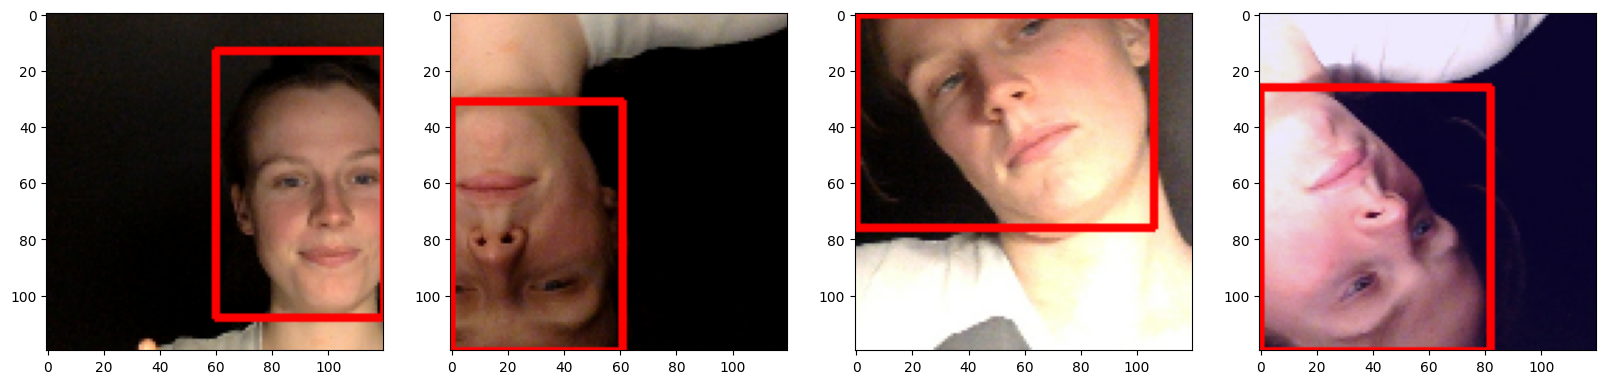

In [46]:
fif, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    print(sample_coords)

    # Normalizacja obrazu
    normalized_image_np = cv2.normalize(sample_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    sample_image_umat = cv2.UMat(normalized_image_np)

    # Wywołanie funkcji cv2.rectangle na obiekcie UMat
    cv2.rectangle(sample_image_umat,
              tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
              tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
              (255,0,0),2)

    # Wyświetlenie znormalizowanego obrazu
    ax[idx].imshow(sample_image_umat.get())
    # ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

## 8.1 Import Layers and Base Network
Zaimportowane też powyżej (razem ze wszystkimi)

*Czym jest VGG16?*
To model sieci neuronowej konwolucyjnej (CNN).
Model VGG16 składa się z 16 warstw konwolucyjnych i poolingowych, a następnie warstw w pełni połączonych. Każda warstwa konwolucyjna w modelu VGG16 składa się z serii filtrów konwolucyjnych o małym rozmiarze (zazwyczaj 3x3) z funkcją aktywacji ReLU oraz warstw poolingowych, które zmniejszają wymiary przestrzenne map cech.

In [47]:
from tensorflow.keras.models import Model # bazowy model tesoflow
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG16

In [48]:
# odcinamy koniec, bo jest to model tylko do klasyfikacji, a końcówkę chcemy zastąpić regresją
vgg = VGG16(include_top=False)

In [49]:
vgg.summary() # wyświetla informację o sieciach neuronowych
# (ilość próbek, szerokość, wysokość, ilość kanałów)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## 8.3 Build instance of Network

In [71]:
def build_model(): 
    input_layer = Input(shape=(120,120,3)) # wejście o wymiarach 120x120x3 pikseli
    
    vgg = VGG16(include_top=False)(input_layer)

    # Model klasyfikacji  
    f1 = GlobalMaxPooling2D()(vgg) # wyjścia w vgg
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1) # jedno wyjscie
    
    # Model ramki ograniczającej
    f2 = GlobalMaxPooling2D()(vgg) # jakoś kondensuje ilość wejść
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1) # 4 wyjscia
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2]) # dwa wyjścia
    # wyjście z klasyfikacji i wyjście z regresji
    # class2 jest jedna wartoscia z przedzialu [0,1] ponieważ wykorzystuję sigmoidę
    # regress2 sklada się z 4 elementów z przedziału [0,1]
    return facetracker

## 8.4 Test out Neural Network

In [51]:
facetracker = build_model() #zdefiniuj model

In [52]:
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
X, y = train.as_numpy_iterator().next()

2024-05-10 15:56:57.331877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 4366 of 10000
2024-05-10 15:57:03.812175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


In [54]:
X.shape

(8, 120, 120, 3)

In [55]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


In [56]:
classes, coords

(array([[0.4794674 ],
        [0.50728667],
        [0.48041934],
        [0.4885898 ],
        [0.47205666],
        [0.49816436],
        [0.41858035],
        [0.52851677]], dtype=float32),
 array([[0.60668844, 0.61217886, 0.67405874, 0.4834641 ],
        [0.6101144 , 0.63817114, 0.6730675 , 0.43538716],
        [0.68919283, 0.6459379 , 0.62572545, 0.4572351 ],
        [0.6501774 , 0.5780294 , 0.723011  , 0.48025283],
        [0.6383678 , 0.6507699 , 0.69555885, 0.53052986],
        [0.64864707, 0.64666986, 0.6573692 , 0.52376163],
        [0.6648337 , 0.6082688 , 0.6310492 , 0.53548133],
        [0.6738846 , 0.63088703, 0.62862676, 0.48652026]], dtype=float32))

# 9. Define Losses and Optimizers

## 9.1 Define Optimizer and LR

In [57]:
batches_per_epoch = len(train) # ilość danych uczących na epokę
lr_decay = (1./0.75 -1)/batches_per_epoch # spadek szybkości uczenia się
print('batches_per_epoch ' + str(batches_per_epoch) )
print('lr_decay ' + str(lr_decay))

batches_per_epoch 908
lr_decay 0.0003671071953010278


In [58]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/usr/local/Cellar/jupyterlab/4.1.6_1/libexec/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [59]:

def localization_loss(y_true, yhat):     
    # różnica pomiędzy rzeczywistym a przewidywanym koordynatem(rogiem)
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    # różnica pomiędzy rzeczywistymi a przewidywanymi długościami prostokąta
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    # zwraxa sumę błędów
    return delta_coord + delta_size

In [60]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [61]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=12.676885>

In [62]:
classloss(y[0], classes)
# classloss(y[0], classes).numpy()

<tf.Tensor: shape=(), dtype=float32, numpy=0.6863164>

In [63]:
regressloss(y[1], coords)
# regressloss(y[1], coords).numpy()

<tf.Tensor: shape=(), dtype=float32, numpy=12.676885>

# 10. Train Neural Network

## 10.1 Create Custom Model Class

In [64]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [65]:
model = FaceTracker(facetracker)

In [66]:
model.compile(opt, classloss, regressloss)

# 10.2 Train

In [67]:
logdir='logs'

In [68]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [69]:
print("Shape of y[0]:", y[0].shape)
print("Shape of classes:", classes.shape)

Shape of y[0]: (8, 1)
Shape of classes: (8, 1)


In [70]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


ValueError: Cannot take the length of shape with unknown rank.

# 10.3 Plot Performance

# 11. Make Predictions

## 11.1 Make Predictions on Test Set

## 11.2 Save the Model

## 11.3 Real Time Detection  FINAL!!!!